In [5]:
import os
import sys
from argparse import Namespace
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# own code
sys.path.append('../')
from datasets import DeepRiskDataset2D, MyopsDataset2D
from resnet import LightningResNet
from simplenet import LightningSimpleNet
from train_classifier_2d import load_dataset

Some code to try out data augmentations and check whether they give appropiate results.

We don't want transformation to get so crazy that classification becomes impossible.

This notebook might need some updates to function with changes in the rest of the code.

In [6]:
def example_transforms_gen(dataloader):
    # use to see if the chosen tranforms lead to reasonable images
    # Always using the same image
    while True:
        _, inputs, labels = next(iter(dataloader)) 
        inputs = inputs.to(device)
        labels = labels.to(device)

        print("label: ", labels[0].item())
        print("max/min value", inputs[0][0].max().item(), inputs[0][0].min().item())


        fig, axs = plt.subplots(figsize=(6, 6))
        #fig.suptitle(f"label: {labels[0].item()}, predicted: {preds[0].item()}")
        axs.imshow(inputs[0][0], cmap="gray")
        plt.show()
        yield
    
def dataset_examples_gen(dataloader):
    # plot image and label to see if they are correct
    for _, inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        for i in range(len(inputs)):
            print("label: ", labels[i].item())
            print("max/min value", inputs[i][0].max().item(), inputs[i][0].min().item())

            fig, axs = plt.subplots(figsize=(6, 6))
            print(f'{inputs.shape=}')
            axs.imshow(inputs[i][0], cmap="gray")
            plt.show()
            yield
    
def check_batch_sizes(dataloader, correct_shape):
    for _, inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        if not (inputs.shape[1] == correct_shape[1] and inputs.shape[1] == correct_shape[1] and inputs.shape[2] == correct_shape[2] and inputs.shape[3] == correct_shape[3] ):
            yield inputs

# Setup dataloaders

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hparams = Namespace()
# choose dataset
hparams.dataset = 'deeprisk'
# reproducability
hparams.trainseed = 42
hparams.splitseed = 42
hparams.train_frac = 0.8
# paths
hparams.data_path = r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\data"
hparams.img_path = r"all_niftis_n=657"
hparams.weak_labels_path = r"weak_labels_n=657.xlsx"
hparams.myoseg_path = r"nnUnet_results\nnUNet\2d\Task500_MyocardSegmentation\predictions"
# data augmentation
hparams.image_norm = "global_statistic"
hparams.no_roi_crop = False
hparams.include_no_myo = False
hparams.roi_crop = "fixed" # "fitted", or "fixed"
hparams.center_crop = 224
hparams.input_size = 224
hparams.rotate = 90
hparams.translate = (0.1, 0.1)
hparams.scale = (1, 1)
hparams.shear = (-5, 5, -5, 5)
hparams.brightness = 0.3
hparams.contrast = 0.3
hparams.hflip = True
hparams.vflip = True
print(f'{hparams=}')

pl.seed_everything(hparams.trainseed, workers=True)
# prepare dataloaders
dataset_train, dataset_val = load_dataset(hparams)
print(f"Train data: {len(dataset_train)}, validation data {len(dataset_val)}")

train_loader = DataLoader(dataset_train,
                            batch_size=8,
                            shuffle=False,
                            drop_last=False,
                            num_workers=1)
val_loader = DataLoader(dataset_val,
                        batch_size=8,
                        shuffle=False,
                        drop_last=False,
                        num_workers=1)
# dataloaders
#deeprisk_train = DeepRiskDataset2D(IMG_DIR, LABELS_FILE, transform=train_transforms, train=True, train_frac = 0.8, split_seed=42, myoseg_dir=MYOSEG_DIR) 
#deeprisk_val = DeepRiskDataset2D(IMG_DIR, LABELS_FILE, transform=val_transforms, train=False, train_frac = 0.8, split_seed=42, myoseg_dir=MYOSEG_DIR)
#print("train slices:", len(deeprisk_train), "positive:", len([x for x in deeprisk_train.labels if x == 1]))
#print("val slices:", len(deeprisk_val), "positive:", len([x for x in deeprisk_val.labels if x == 1]))
#print(train_transforms)
#print(val_transforms)

#train_dataloader = DataLoader(deeprisk_train, batch_size=8, shuffle=False)
#val_dataloader = DataLoader(deeprisk_val, batch_size=8, shuffle=False)
#dataloaders = {'train': train_dataloader, 'val' : val_dataloader}
#dataset_sizes = {'train' : len(deeprisk_train), 'val' :len(deeprisk_val) }"""

Global seed set to 42


hparams=Namespace(brightness=0, center_crop=224, contrast=0, data_path='\\\\amc.intra\\users\\R\\rcklein\\home\\deeprisk\\weakly_supervised\\data', dataset='deeprisk', hflip=True, image_norm='global_statistic', img_path='all_niftis_n=657', include_no_myo=False, input_size=224, myoseg_path='nnUnet_results\\nnUNet\\2d\\Task500_MyocardSegmentation\\predictions', no_roi_crop=False, roi_crop='fixed', rotate=0, scale=(1, 1), shear=(0, 0, 0, 0), splitseed=42, train_frac=0.8, trainseed=42, translate=(0, 0), vflip=True, weak_labels_path='weak_labels_n=657.xlsx')
train transforms:
Compose(
    Resize(size=(224, 224), interpolation=bicubic, max_size=None, antialias=None)
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
    Normalize(mean=[0.57], std=[0.06])
    RandomAffine(degrees=[0.0, 0.0], scale=(1, 1), shear=[0.0, 0.0, 0.0, 0.0], interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
)
val_transforms:
Compose(
    Resize(size=(224, 224

# Check examples

In [9]:
# visualization generators
example_transforms = example_transforms_gen(train_loader)
train_examples = dataset_examples_gen(train_loader)
val_examples = dataset_examples_gen(val_loader)

label:  0
max/min value 3.497976064682007 -3.5207903385162354


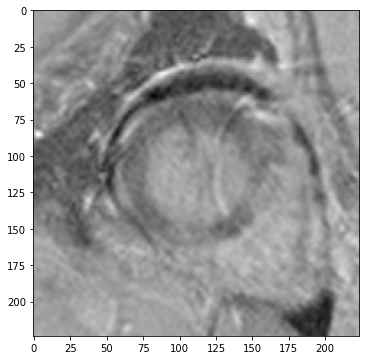

In [12]:
next(example_transforms)

label:  1
max/min value 1.9444793462753296 -2.987043619155884
inputs.shape=torch.Size([8, 1, 224, 224])


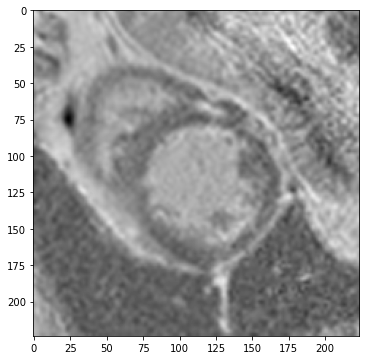

In [36]:
next(train_examples)

label:  1
max/min value 7.698147773742676 -4.7236247062683105
inputs.shape=torch.Size([8, 1, 224, 224])


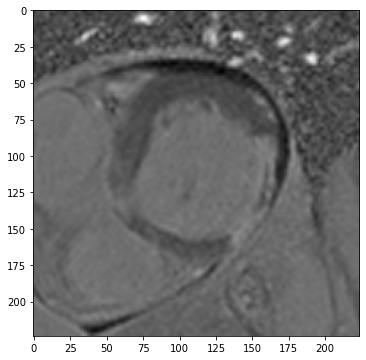

In [47]:
next(val_examples)